# Natural Language Processing (NLP) and Neural Networks with NLTK and the Tensorflow Keras API

### Introduction

In this notebook, I will be building a model to predict whether or not a tweet is about a real disaster, using the data given for the assignment. The data has been provided in separate training and test sets, so only the training set will be used in the model training/validation while the test set will be saved for the end to evalute the model.

First the data will be loaded and explored, then the data will be cleaned and preprocessed, and finally the model will be built and trained. I decided to add some features to the data set (e.g. number of words in a tweet) to see if they would improve the model's performance. I also used the prebuild sentiment analysis model from the NLTK library to see if it would improve the model's performance. Finally I used the sklearn library to vectorize the text data with the TF-IDF vectorizer and the nltk tweet tokenizer to tokenize the text data. After all of this, I used the tensorflow.keras library to build and train the neural network. The metrics used to evaluate the model were the accuracy score and receiver operating characteristic (ROC) curve.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import random

In [2]:
random.seed(42)

In [3]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

### Custom Functions

1. *dtype_convert*: converts the data type of a column in a dataframe

2. *link_count*: if a link exists in a tweet
2. *get_polarity*: returns the polarity of a tweet using the NLTK sentiment analysis model
2. *return_xy*: returns the x and y data from a dataframe
2. *return_vectorized_data*: returns the vectorized text and extra features from a dataframe
2. *plot_history*: plots the training and validation accuracy and loss from a history object
2. *plot_roc*: plots the ROC curve using the best saved model and the test data

In [5]:
def dtype_convert(data : pd.DataFrame):
    """Converts the data types of the numeric columns in a dataframe to the smallest possible type.
    
    Parameters
    ----------
    data : pd.DataFrame to have its numeric columns converted.
    """

    int_list = ['int8', 'int16', 'int32', 'int64']
    float_list = ['float16', 'float32', 'float64']

    for col in data.select_dtypes(include=np.number).columns:

        data_type = data[col].dtype
        
        # Convert to int
        if data_type in int_list:

            n_range = [abs(data[col].max()), abs(data[col].min())]
            n_max = max(n_range)

            if n_max <= 127:
                data[col] = data[col].astype(np.int8)

            elif n_max <= 32767:
                data[col] = data[col].astype(np.int16)

            elif n_max <= 2147483647:
                data[col] = data[col].astype(np.int32)

            else:
                data[col] = data[col].astype(np.int64)

        # Convert to float
        elif data_type in float_list:
                
                n_range = [abs(data[col].max()), abs(data[col].min())]
                n_max = max(n_range)
    
                if n_max <= 3.4e+38:
                    data[col] = data[col].astype(np.float32)
    
                else:
                    data[col] = data[col].astype(np.float64)
    
    return data
        

In [6]:
def link_count(text : str):
    """Returns binary value indicating whether a tweet contains a link or not.
    
    Parameters
    ----------
    text : str to be checked for links."""

    # Checks string for http
    links = text.count('http')

    if links > 0:
        return 1
    
    else:
        return 0

In [7]:
def get_polarity(row : pd.Series):
    """Returns the polarity of a tweet using the VADER sentiment analyzer from NLTK.
    
    Parameters
    ----------
    row : pd.Series (to be applied on rows of pd.DataFrame) containing the text of a tweet."""

    sia = SentimentIntensityAnalyzer()

    text = row['text']
    polarity = sia.polarity_scores(text)

    neg = polarity['neg']
    neu = polarity['neu']
    pos = polarity['pos']
    compound = polarity['compound']

    return neg, neu, pos, compound

In [8]:
def return_xy(data):

    # Add new features including polarity scores
    # Binary feature for whether a tweet contains a link
    data['links_f'] = data['text'].apply(link_count).astype(np.int8)
    
    data['tweet_len'] = data['text'].str.len()
    data['word_count'] = data['text'].str.split().str.len()
    data['word_density'] = data['tweet_len'] / (data['word_count'])

    # Get polarity scores
    print('Getting polarity scores...')
    data['neg'], data['neu'], data['pos'], data['compound_f'] = zip(*data.apply(get_polarity, axis=1))

    # Convert dtypes to save memory
    #data['target'] = data['target'].astype('bool')
    data = dtype_convert(data)
    
    # Columns for X and y
    X = data.drop('target', axis=1)
    y = data['target'].astype('int8')

    return X, y

In [9]:
def return_vectorized_data(train : pd.DataFrame, test : pd.DataFrame, text : list, features : list,
                           max_features=None, stop_words=None):
    """Returns vectorized data for training and testing.

    Parameters
    ----------
    train : pd.DataFrame containing training data.
    test : pd.DataFrame containing testing data.
    text : str indicating the column name of the text data.
    features : list of str indicating the column names of the numeric features.
    max_features : int indicating the maximum number of features to be used in the vectorizer.
    stop_words : list of str indicating the stop words to be used in the vectorizer.
    """

    tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    vectorizer = TfidfVectorizer(tokenizer=tk.tokenize, strip_accents='unicode', max_features=max_features, stop_words=stop_words)

    v_train = vectorizer.fit_transform(train[text])
    v_test = vectorizer.transform(test[text])

    v_train = pd.DataFrame(v_train.toarray(), columns=vectorizer.get_feature_names_out(), index=train.index)
    v_test = pd.DataFrame(v_test.toarray(), columns=vectorizer.get_feature_names_out(), index=test.index)

    v_train = v_train[v_train.columns].astype(np.float32)
    v_test = v_test[v_test.columns].astype(np.float32)

    v_train = v_train.join(train[features], how='left', lsuffix='_v', rsuffix='_f')
    v_test = v_test.join(test[features], how='left', lsuffix='_v', rsuffix='_f')

    return v_train, v_test

In [10]:
def plot_history(history):
    """Plots the training and validation loss and accuracy for a model.

    Parameters
    ----------
    history : Keras history object.
    """

    fig, ax = plt.subplots(2, 1, figsize=(11, 11))

    auc_best = np.max(history.history['val_auc'])
    auc_best_epoch = np.argmax(history.history['val_auc'])
    auc_max = history.history['auc'][auc_best_epoch]


    ax[0].plot(history.history['auc'], label='Train')
    ax[0].plot(history.history['val_auc'], label='Validation')
    ax[0].vlines(auc_best_epoch, 0, np.max(history.history['val_auc']), color='purple', linestyles='dashed', label='Best Epoch')

    ax[0].annotate(f'{auc_best - np.max(history.history["auc"]):.4f}',
                    xy=(auc_best_epoch, auc_max),
                    xytext=(auc_best_epoch, auc_best-0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.7, headwidth=5))

    ax[0].set_ylabel('AUC')
    #ax[0].set_title('AUC vs. Epoch')
    ax[0].legend(loc='lower left')

    loss_best = np.min(history.history['val_loss'])
    loss_best_epoch = np.argmin(history.history['val_loss'])
    loss_max = history.history['loss'][loss_best_epoch]

    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Validation')
    ax[1].vlines(loss_best_epoch, 0, loss_best, color='purple', linestyles='dashed', label='Best Epoch')

    ax[1].annotate(f'{loss_best - np.min(history.history["loss"]):.4f}',
                    xy=(loss_best_epoch, loss_max),
                    xytext=(loss_best_epoch, loss_best+.01),
                    arrowprops=dict(facecolor='black', shrink=0, width=0.7, headwidth=5))

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    #ax[1].set_title('Loss vs. Epoch')

    ax[1].legend(loc='lower left')

    plt.show()

In [11]:
def plot_roc(X_train, X_test, y_train, y_test, model):
    """Plots the ROC AUC curve for a model.

    Parameters
    ----------
    X_train : pd.DataFrame or numpy array containing the training data.
    X_test : pd.DataFrame or numpy array containing the testing data.
    y_train : pd.Series or numpy array containing the training target.
    y_test : pd.Series or numpy array containing the testing target.
    model : Keras model.
    """
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict(X_train))
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model.predict(X_test))

    # Set figure size
    plt.figure(figsize=(10, 10))

    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')

    plt.legend(['Train', 'Test'], loc='upper left')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.show()

### Import Data

In [12]:
train_data = pd.read_csv('projects/data/bonus_train_data-2.csv')
test_data = pd.read_csv('projects/data/bonus_test_data-2.csv')

Now that the data has been loaded, I will explore it to get an idea of what I am working with. It is important to make sure that the data is clean and that there are no missing values. I will then print some random samples from the data to get an idea of what the tweets look like. We may see some instances where the target is 1 (real disaster) but the tweet is not about a real disaster. This is important to keep in mind when training the model that we might be limited by the quality of the data.

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6090 entries, 0 to 6089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6090 non-null   object
 1   target  6090 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.3+ KB


In [14]:
train_data

,text,target
0,Courageous and honest analysis of need to use ...,1
1,@ZachZaidman @670TheScore wld b a shame if tha...,0
2,Tell @BarackObama to rescind medals of 'honor'...,1
3,Worried about how the CA drought might affect ...,1
4,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0
...,...,...
6085,@Eganator2000 There aren't many Obliteration s...,0
6086,just had a panic attack bc I don't have enough...,0
6087,Omron HEM-712C Automatic Blood Pressure Monito...,0
6088,Officials say a quarantine is in place at an A...,1


In [15]:
for i in range(1, 9):
    rand = np.random.randint(0, len(train_data)-1)
    text = train_data.loc[rand, 'text']
    target = train_data.loc[rand, 'target']
    print(f'Index: {rand}')
    print(f'Target: {target}\n{text}\n')

Index: 3895
Target: 0
@MistressPip I'm amazed you have not been inundated mistress.

Index: 5303
Target: 1
New York City Outbreak: What Is Legionnaire's Disease?   http://t.co/CXI82rFiFS

Index: 1459
Target: 0
I feel like death

Index: 5454
Target: 1
#ABCNews Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for No... http://t.co/DOBZc3piTM #World

Index: 942
Target: 0
Enugu Government to demolish illegal structures at International Conference Centre: Enugu State government app... http://t.co/MsKn6D3eKH

Index: 2843
Target: 0
People really still be having curfew even when they're 18 &amp; graduated high school ??

Index: 1114
Target: 1
Severe Thunderstorm Warning including Russellville AR Clarksville AR Dardanelle AR until 10:15 PM CDT http://t.co/n844h1ASPj

Index: 3884
Target: 1
A look at state actions a year after Ferguson's upheaval http://t.co/vXUFtVT9AU



### Add Features

In [16]:
X_train, y_train = return_xy(train_data)
X_test, y_test = return_xy(test_data)

features = ['tweet_len', 'word_count', 'word_density', 'links_f', 'neg', 'neu', 'pos', 'compound_f']

Getting polarity scores...
Getting polarity scores...


### Tokenize and Vectorize Data

In [17]:
# Runs the custom function to vectorize the data
X_train_v, X_test_v = return_vectorized_data(X_train, X_test, 'text', features=features, max_features=None, stop_words=stop_words)

In [18]:
X_train_v[features]

,tweet_len,word_count,word_density,links_f,neg,neu,pos,compound_f
0,140,18,7.777778,1,0.207,0.536,0.257,0.3182
1,98,15,6.533333,0,0.205,0.795,0.000,-0.4767
2,143,22,6.500000,1,0.000,1.000,0.000,0.0000
3,118,17,6.941176,1,0.138,0.862,0.000,-0.3736
4,82,9,9.111111,0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
6085,96,16,6.000000,0,0.000,0.502,0.498,0.9169
6086,132,28,4.714286,0,0.276,0.724,0.000,-0.8126
6087,121,13,9.307693,1,0.155,0.845,0.000,-0.2960
6088,136,20,6.800000,1,0.000,1.000,0.000,0.0000


In [19]:
vectors = [col for col in X_train_v.columns if col not in features]
X_train_v[vectors]

,!,#,##book,##youtube,#034,#039,#06,#09,#1-1st,#1008pla,...,,¡,¢,£,¤,©,«,¬,÷,⁄
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.118436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6086,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6087,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6088,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scale Data

In [20]:
# import sklearn standard scaler
from sklearn.preprocessing import StandardScaler

In [21]:
X_train_f = X_train_v[features]
X_test_f = X_test_v[features]

# instantiate the scaler
scaler = StandardScaler()

# fit transform the training data
X_train_fs = scaler.fit_transform(X_train_f)
X_test_fs = scaler.transform(X_test_f)

X_train_fs = pd.DataFrame(X_train_fs, columns=features, index=X_train_f.index)
X_test_fs = pd.DataFrame(X_test_fs, columns=features, index=X_test_f.index)

X_train_v[features] = X_train_fs[features]
X_test_v[features] = X_test_fs[features]

### Train Model

First we convert the dataframes to numpy arrays to work with the keras api. I used the functional api to build the model. It has two hidden layers, a concatenated layer of the original input and previous hidden layers, and one more hidden layer before the output layer. I used the Adam optimizer and the binary crossentropy loss function. I also used the early stopping and checkpoint callbacks to save the best model. I used the fit method to train the model.

In [22]:
train_text = X_train_v.drop(features, axis=1)
test_text = X_test_v.drop(features, axis=1)

train_feats = X_train_v[features]
test_feats = X_test_v[features]

In [23]:
train_text_n = train_text.to_numpy()
test_text_n = test_text.to_numpy()

train_feats_n = train_feats.to_numpy()
test_feats_n = test_feats.to_numpy()

y_train_n = y_train.to_numpy()
y_test_n = y_test.to_numpy()

In [24]:
tf.keras.backend.clear_session()

act1 = tf.keras.layers.LeakyReLU(alpha=0.05)

text_input_ = tf.keras.layers.Input(shape=(train_text_n.shape[1],), name='text_input')
text_layers = tf.keras.layers.Dense(32, activation=act1)(text_input_)
#text_layers = tf.keras.layers.Dropout(0.2)(text_layers)

feats_input_ = tf.keras.layers.Input(shape=(train_feats_n.shape[1],), name='feats_input')
feats_layers = tf.keras.layers.Dense(32, activation=act1)(feats_input_)
feats_layers = tf.keras.layers.Dropout(0.1)(feats_layers)

concat_l = tf.keras.layers.Concatenate()([text_layers, feats_layers])
concat_i = tf.keras.layers.Concatenate()([text_input_, feats_input_])

concat = tf.keras.layers.Concatenate()([concat_l, concat_i])
concat = tf.keras.layers.Dropout(0.1)(concat)

output_ = tf.keras.layers.Dense(1, activation='sigmoid')(concat)

model = tf.keras.Model(inputs=[text_input_, feats_input_], outputs=output_)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feats_input (InputLayer)       [(None, 8)]          0           []                               
                                                                                                  
 text_input (InputLayer)        [(None, 17781)]      0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 32)           288         ['feats_input[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 32)           569024      ['text_input[0][0]']             
                                                                                              

In [25]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0003)
metric = tf.keras.metrics.AUC()

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metric)

In [26]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=4, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint.hd5', monitor='val_auc', save_best_only=True, mode='max')
             ]

model_results = model.fit([train_text, train_feats], y_train_n, validation_split=0.02,
                          epochs=100, batch_size=64, callbacks=callbacks,
                          use_multiprocessing=True)

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 0.6846 - auc: 0.6286INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 4s 39ms/step - loss: 0.6846 - auc: 0.6286 - val_loss: 0.6754 - val_auc: 0.7030
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.6690 - auc: 0.7009INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 32ms/step - loss: 0.6690 - auc: 0.7009 - val_loss: 0.6590 - val_auc: 0.7297
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.6553 - auc: 0.7164INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 28ms/step - loss: 0.6553 - auc: 0.7164 - val_loss: 0.6447 - val_auc: 0.7473
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.6438 - auc: 0.7232INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 27ms/step - loss: 0.6438 - auc: 0.7232 - val_loss: 0.6327 - val_auc: 0.7508
Epoch 5/100
93/94 [============================>.] - ETA: 0s - loss: 0.6329 - auc: 0.7321INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.6329 - auc: 0.7323 - val_loss: 0.6209 - val_auc: 0.7559
Epoch 6/100
93/94 [============================>.] - ETA: 0s - loss: 0.6225 - auc: 0.7389INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 27ms/step - loss: 0.6224 - auc: 0.7394 - val_loss: 0.6105 - val_auc: 0.7620
Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 0.6139 - auc: 0.7446INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.6139 - auc: 0.7446 - val_loss: 0.6012 - val_auc: 0.7672
Epoch 8/100
94/94 [==============================] - ETA: 0s - loss: 0.6037 - auc: 0.7547INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.6037 - auc: 0.7547 - val_loss: 0.5927 - val_auc: 0.7718
Epoch 9/100
92/94 [============================>.] - ETA: 0s - loss: 0.5983 - auc: 0.7567INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 22ms/step - loss: 0.5973 - auc: 0.7584 - val_loss: 0.5854 - val_auc: 0.7766
Epoch 10/100
93/94 [============================>.] - ETA: 0s - loss: 0.5892 - auc: 0.7662INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.5893 - auc: 0.7660 - val_loss: 0.5783 - val_auc: 0.7807
Epoch 11/100
93/94 [============================>.] - ETA: 0s - loss: 0.5833 - auc: 0.7704INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.5834 - auc: 0.7701 - val_loss: 0.5718 - val_auc: 0.7842
Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.5742 - auc: 0.7810INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.5742 - auc: 0.7810 - val_loss: 0.5656 - val_auc: 0.7907
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.5676 - auc: 0.7875INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.5676 - auc: 0.7875 - val_loss: 0.5598 - val_auc: 0.7955
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.5609 - auc: 0.7945INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.5609 - auc: 0.7945 - val_loss: 0.5544 - val_auc: 0.7990
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.5538 - auc: 0.8022INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 28ms/step - loss: 0.5538 - auc: 0.8022 - val_loss: 0.5489 - val_auc: 0.8049
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.5455 - auc: 0.8120INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.5455 - auc: 0.8120 - val_loss: 0.5435 - val_auc: 0.8090
Epoch 17/100
93/94 [============================>.] - ETA: 0s - loss: 0.5376 - auc: 0.8194INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 28ms/step - loss: 0.5378 - auc: 0.8192 - val_loss: 0.5380 - val_auc: 0.8132
Epoch 18/100
94/94 [==============================] - ETA: 0s - loss: 0.5304 - auc: 0.8267INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.5304 - auc: 0.8267 - val_loss: 0.5329 - val_auc: 0.8168
Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.5220 - auc: 0.8360INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.5220 - auc: 0.8360 - val_loss: 0.5276 - val_auc: 0.8202
Epoch 20/100
92/94 [============================>.] - ETA: 0s - loss: 0.5144 - auc: 0.8429INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.5148 - auc: 0.8423 - val_loss: 0.5224 - val_auc: 0.8261
Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.5064 - auc: 0.8504INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.5064 - auc: 0.8504 - val_loss: 0.5175 - val_auc: 0.8317
Epoch 22/100
94/94 [==============================] - ETA: 0s - loss: 0.4990 - auc: 0.8572INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4990 - auc: 0.8572 - val_loss: 0.5126 - val_auc: 0.8380
Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.4902 - auc: 0.8655INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4902 - auc: 0.8655 - val_loss: 0.5073 - val_auc: 0.8424
Epoch 24/100
94/94 [==============================] - ETA: 0s - loss: 0.4816 - auc: 0.8733INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4816 - auc: 0.8733 - val_loss: 0.5028 - val_auc: 0.8452
Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.4743 - auc: 0.8796INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 29ms/step - loss: 0.4743 - auc: 0.8796 - val_loss: 0.4984 - val_auc: 0.8482
Epoch 26/100
93/94 [============================>.] - ETA: 0s - loss: 0.4670 - auc: 0.8860INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4667 - auc: 0.8861 - val_loss: 0.4940 - val_auc: 0.8493
Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.4596 - auc: 0.8910INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 22ms/step - loss: 0.4596 - auc: 0.8910 - val_loss: 0.4895 - val_auc: 0.8521
Epoch 28/100
93/94 [============================>.] - ETA: 0s - loss: 0.4505 - auc: 0.8981INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4504 - auc: 0.8982 - val_loss: 0.4851 - val_auc: 0.8556
Epoch 29/100
94/94 [==============================] - ETA: 0s - loss: 0.4438 - auc: 0.9017INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.4438 - auc: 0.9017 - val_loss: 0.4807 - val_auc: 0.8581
Epoch 30/100
94/94 [==============================] - ETA: 0s - loss: 0.4357 - auc: 0.9072INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 26ms/step - loss: 0.4357 - auc: 0.9072 - val_loss: 0.4766 - val_auc: 0.8592
Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.4285 - auc: 0.9120INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 3s 27ms/step - loss: 0.4285 - auc: 0.9120 - val_loss: 0.4726 - val_auc: 0.8610
Epoch 32/100
89/94 [===========================>..] - ETA: 0s - loss: 0.4195 - auc: 0.9183INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.4199 - auc: 0.9176 - val_loss: 0.4686 - val_auc: 0.8626
Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.4126 - auc: 0.9218INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.4126 - auc: 0.9218 - val_loss: 0.4648 - val_auc: 0.8642
Epoch 34/100
94/94 [==============================] - 1s 12ms/step - loss: 0.4058 - auc: 0.9249 - val_loss: 0.4612 - val_auc: 0.8629
Epoch 35/100
93/94 [============================>.] - ETA: 0s - loss: 0.3988 - auc: 0.9282INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.3989 - auc: 0.9282 - val_loss: 0.4580 - val_auc: 0.8645
Epoch 36/100
93/94 [============================>.] - ETA: 0s - loss: 0.3915 - auc: 0.9323INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 27ms/step - loss: 0.3916 - auc: 0.9322 - val_loss: 0.4547 - val_auc: 0.8656
Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.3845 - auc: 0.9364INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.3845 - auc: 0.9364 - val_loss: 0.4515 - val_auc: 0.8675
Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.3781 - auc: 0.9384INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.3781 - auc: 0.9384 - val_loss: 0.4484 - val_auc: 0.8682
Epoch 39/100
91/94 [============================>.] - ETA: 0s - loss: 0.3742 - auc: 0.9393INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.3733 - auc: 0.9399 - val_loss: 0.4457 - val_auc: 0.8697
Epoch 40/100
93/94 [============================>.] - ETA: 0s - loss: 0.3657 - auc: 0.9435INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.3657 - auc: 0.9435 - val_loss: 0.4426 - val_auc: 0.8701
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.3610 - auc: 0.9445INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.3610 - auc: 0.9445 - val_loss: 0.4398 - val_auc: 0.8730
Epoch 42/100
92/94 [============================>.] - ETA: 0s - loss: 0.3548 - auc: 0.9471INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 22ms/step - loss: 0.3538 - auc: 0.9478 - val_loss: 0.4370 - val_auc: 0.8737
Epoch 43/100
94/94 [==============================] - ETA: 0s - loss: 0.3470 - auc: 0.9504INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.3470 - auc: 0.9504 - val_loss: 0.4340 - val_auc: 0.8744
Epoch 44/100
93/94 [============================>.] - ETA: 0s - loss: 0.3415 - auc: 0.9525INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.3415 - auc: 0.9526 - val_loss: 0.4315 - val_auc: 0.8745
Epoch 45/100
92/94 [============================>.] - ETA: 0s - loss: 0.3359 - auc: 0.9542INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.3364 - auc: 0.9540 - val_loss: 0.4291 - val_auc: 0.8767
Epoch 46/100
94/94 [==============================] - ETA: 0s - loss: 0.3300 - auc: 0.9557INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.3300 - auc: 0.9557 - val_loss: 0.4269 - val_auc: 0.8797
Epoch 47/100
92/94 [============================>.] - ETA: 0s - loss: 0.3246 - auc: 0.9574INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.3245 - auc: 0.9575 - val_loss: 0.4248 - val_auc: 0.8797
Epoch 48/100
94/94 [==============================] - ETA: 0s - loss: 0.3182 - auc: 0.9601INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 22ms/step - loss: 0.3182 - auc: 0.9601 - val_loss: 0.4224 - val_auc: 0.8802
Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.3139 - auc: 0.9606INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.3139 - auc: 0.9606 - val_loss: 0.4205 - val_auc: 0.8819
Epoch 50/100
94/94 [==============================] - 1s 12ms/step - loss: 0.3082 - auc: 0.9624 - val_loss: 0.4182 - val_auc: 0.8815
Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.3038 - auc: 0.9631INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.3038 - auc: 0.9631 - val_loss: 0.4163 - val_auc: 0.8820
Epoch 52/100
92/94 [============================>.] - ETA: 0s - loss: 0.2997 - auc: 0.9642INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.2996 - auc: 0.9644 - val_loss: 0.4142 - val_auc: 0.8830
Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.2939 - auc: 0.9653INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2939 - auc: 0.9653 - val_loss: 0.4122 - val_auc: 0.8841
Epoch 54/100
94/94 [==============================] - ETA: 0s - loss: 0.2898 - auc: 0.9667INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.2898 - auc: 0.9667 - val_loss: 0.4108 - val_auc: 0.8852
Epoch 55/100
94/94 [==============================] - ETA: 0s - loss: 0.2841 - auc: 0.9685INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2841 - auc: 0.9685 - val_loss: 0.4093 - val_auc: 0.8861
Epoch 56/100
93/94 [============================>.] - ETA: 0s - loss: 0.2801 - auc: 0.9694INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.2802 - auc: 0.9694 - val_loss: 0.4078 - val_auc: 0.8868
Epoch 57/100
92/94 [============================>.] - ETA: 0s - loss: 0.2773 - auc: 0.9699INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2768 - auc: 0.9700 - val_loss: 0.4064 - val_auc: 0.8869
Epoch 58/100
93/94 [============================>.] - ETA: 0s - loss: 0.2719 - auc: 0.9712INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.2720 - auc: 0.9711 - val_loss: 0.4052 - val_auc: 0.8872
Epoch 59/100
92/94 [============================>.] - ETA: 0s - loss: 0.2678 - auc: 0.9726INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.2676 - auc: 0.9724 - val_loss: 0.4036 - val_auc: 0.8882
Epoch 60/100
94/94 [==============================] - 1s 13ms/step - loss: 0.2631 - auc: 0.9734 - val_loss: 0.4025 - val_auc: 0.8879
Epoch 61/100
94/94 [==============================] - 1s 13ms/step - loss: 0.2604 - auc: 0.9736 - val_loss: 0.4010 - val_auc: 0.8882
Epoch 62/100
94/94 [==============================] - 1s 12ms/step - loss: 0.2566 - auc: 0.9742 - val_loss: 0.3999 - val_auc: 0.8882
Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.2510 - auc: 0.9756INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2510 - auc: 0.9756 - val_loss: 0.3986 - val_auc: 0.8884
Epoch 64/100
94/94 [==============================] - ETA: 0s - loss: 0.2468 - auc: 0.9766INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2468 - auc: 0.9766 - val_loss: 0.3976 - val_auc: 0.8884
Epoch 65/100
94/94 [==============================] - 1s 14ms/step - loss: 0.2421 - auc: 0.9775 - val_loss: 0.3966 - val_auc: 0.8884
Epoch 66/100
94/94 [==============================] - ETA: 0s - loss: 0.2400 - auc: 0.9778INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 21ms/step - loss: 0.2400 - auc: 0.9778 - val_loss: 0.3955 - val_auc: 0.8895
Epoch 67/100
94/94 [==============================] - 1s 16ms/step - loss: 0.2371 - auc: 0.9783 - val_loss: 0.3947 - val_auc: 0.8893
Epoch 68/100
94/94 [==============================] - ETA: 0s - loss: 0.2338 - auc: 0.9789INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.2338 - auc: 0.9789 - val_loss: 0.3934 - val_auc: 0.8898
Epoch 69/100
94/94 [==============================] - 1s 12ms/step - loss: 0.2287 - auc: 0.9803 - val_loss: 0.3927 - val_auc: 0.8893
Epoch 70/100
94/94 [==============================] - ETA: 0s - loss: 0.2254 - auc: 0.9807INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 25ms/step - loss: 0.2254 - auc: 0.9807 - val_loss: 0.3917 - val_auc: 0.8905
Epoch 71/100
94/94 [==============================] - 1s 14ms/step - loss: 0.2216 - auc: 0.9813 - val_loss: 0.3911 - val_auc: 0.8903
Epoch 72/100
93/94 [============================>.] - ETA: 0s - loss: 0.2185 - auc: 0.9823INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 22ms/step - loss: 0.2186 - auc: 0.9823 - val_loss: 0.3902 - val_auc: 0.8908
Epoch 73/100
93/94 [============================>.] - ETA: 0s - loss: 0.2152 - auc: 0.9827INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 24ms/step - loss: 0.2152 - auc: 0.9827 - val_loss: 0.3893 - val_auc: 0.8912
Epoch 74/100
94/94 [==============================] - ETA: 0s - loss: 0.2119 - auc: 0.9831INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 26ms/step - loss: 0.2119 - auc: 0.9831 - val_loss: 0.3887 - val_auc: 0.8925
Epoch 75/100
94/94 [==============================] - 1s 13ms/step - loss: 0.2099 - auc: 0.9832 - val_loss: 0.3882 - val_auc: 0.8920
Epoch 76/100
93/94 [============================>.] - ETA: 0s - loss: 0.2069 - auc: 0.9837INFO:tensorflow:Assets written to: checkpoint.hd5\assets


INFO:tensorflow:Assets written to: checkpoint.hd5\assets


94/94 [==============================] - 2s 23ms/step - loss: 0.2067 - auc: 0.9838 - val_loss: 0.3870 - val_auc: 0.8938
Epoch 77/100
94/94 [==============================] - 1s 12ms/step - loss: 0.2039 - auc: 0.9846 - val_loss: 0.3867 - val_auc: 0.8928
Epoch 78/100
94/94 [==============================] - 1s 16ms/step - loss: 0.1999 - auc: 0.9854 - val_loss: 0.3859 - val_auc: 0.8931
Epoch 79/100
94/94 [==============================] - 1s 14ms/step - loss: 0.1976 - auc: 0.9856 - val_loss: 0.3856 - val_auc: 0.8936
Epoch 80/100
94/94 [==============================] - 1s 15ms/step - loss: 0.1952 - auc: 0.9858 - val_loss: 0.3855 - val_auc: 0.8932


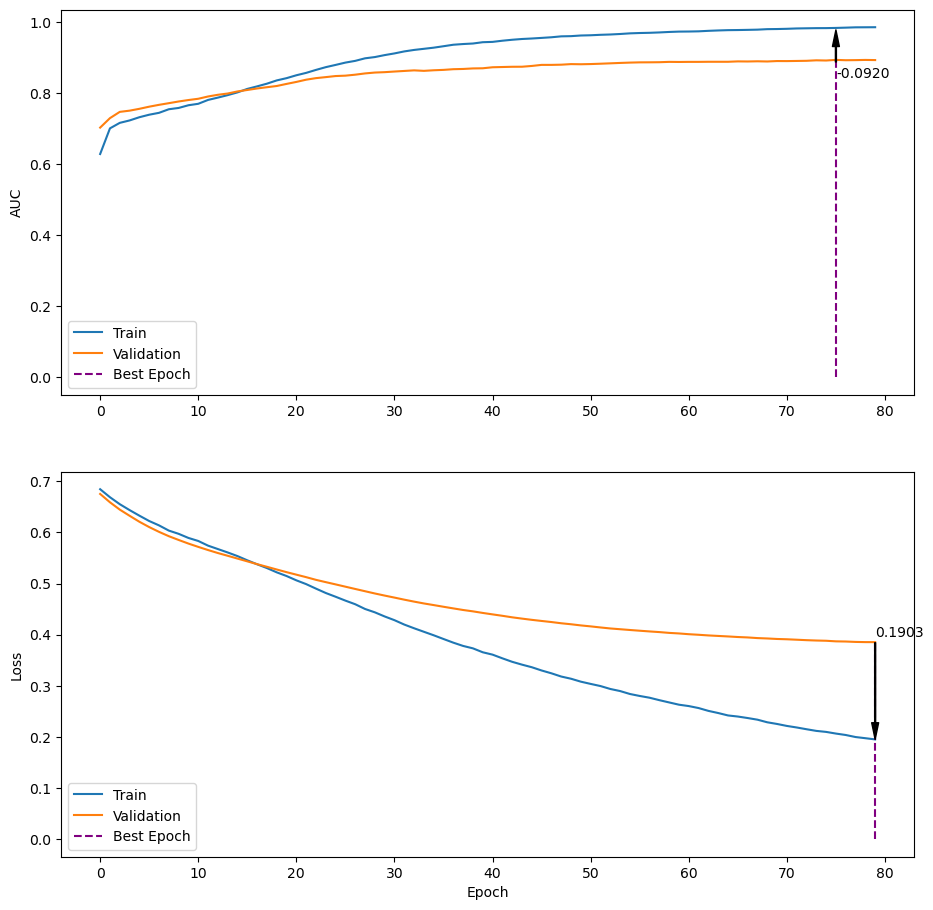

In [27]:
plot_history(model_results)

Above is a plot of the training and validation accuracy and loss. The model seems to be overfitting more as the epochs increase, and we can see the best epoch for loss is around 79, where the best epoch for accuracy is around 76. This indicates that the model may be overfitting and may not perform well when deployed in the real world. However, the model may also be improved by changing the optimizer, learning rate, adding more layers or the amount of training data avaliable.

### Evaluate Model

In [31]:
model.load_weights('checkpoint.hd5')

model.evaluate([test_text, test_feats], y_test_n)

48/48 [==============================] - 2s 35ms/step - loss: 0.4505 - auc: 0.8625


[0.45050153136253357, 0.8624657392501831]

48/48 [==============================] - 2s 36ms/step


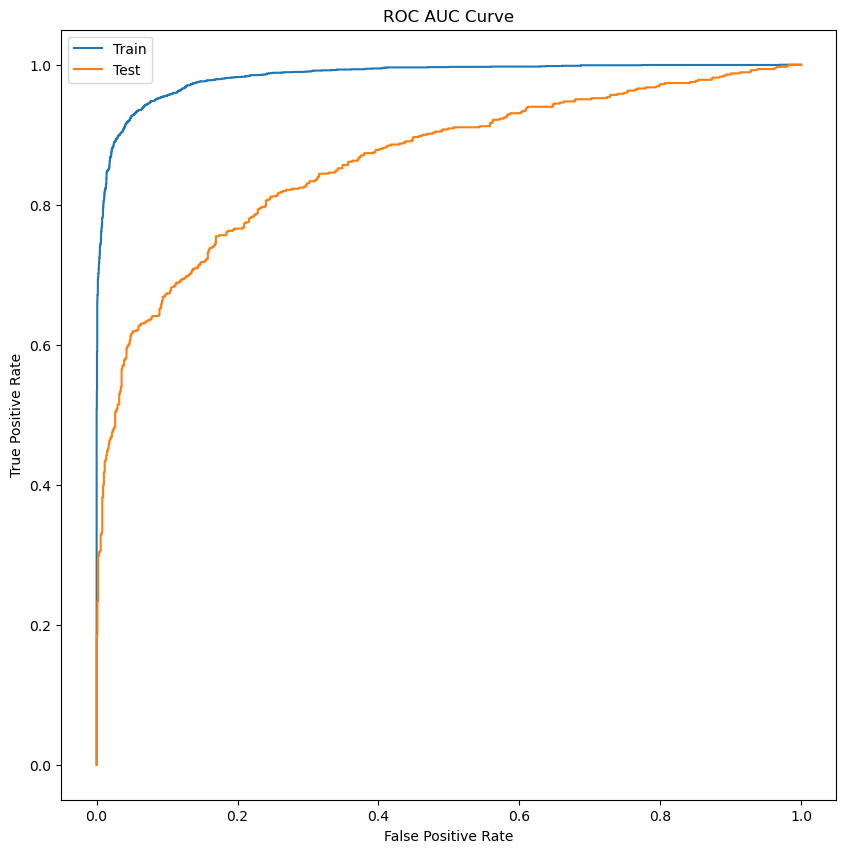

In [29]:
plot_roc([train_text, train_feats], [test_text, test_feats], y_train_n, y_test_n, model)

Above we see the results for our test data set. The model has an AUC of .86, which is not bad. However, from the ROC AUC plot above we can see that the model is still overfitting to the training data and is not generalizing to the test data as well as it could. This could be due to many factors, such as the amount or accuracy of training data, the amount of features, the model architecture, the learning rate, and the amount of epochs. However, the model is still able to predict wheather or not a tweet is about a real disaster with a decent accuracy.